In [11]:
import numpy as np
from scipy import interpolate
import time
import math
import matplotlib.pyplot as plt
# from misc.golden_section_search import Search

In [12]:
"""
Michael Pham
November 2024

much thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational
Methods and Applications, Algorithm 10.1.1

third iteration, version 2 with K, Z, and L as state variable
no consumption tax, no human capital investment structure
"""

'\nMichael Pham\nNovember 2024\n\nmuch thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational\nMethods and Applications, Algorithm 10.1.1\n\nthird iteration, version 2 with K, Z, and L as state variable\nno consumption tax, no human capital investment structure\n'

In [13]:
exp = np.e
log = math.log

In [14]:
# Parameters - households and firms
beta = 0.935  # discount factor
eta = 2.0    # coefficient of relative risk aversion
gamma = 6
chi = 2 #Elasticity of Labor Supply
alpha = 0.33 # capital share in production
delta = 0.1  # depreciation rate
# omega = 0.1  # parent education time factor
# phi_p = 0.5  # share of parental input in education
# psi_e = 0.5  # CES parameter for education inputs
# theta_I = 0.7  # human capital investment effectiveness
tfp = 1      #total factor productivity
small = 0.00001
neg = -1e10

#Parameters - government
tau = 0.15
Ie_gdp = 0.03 # public education investment as percent of GDP
Iz_gdp = 0.06 # public infrastructure investment as percent of GDP percent of GDP
sigma_bar = 0.3  # public investment inefficiency
G_gdp = 0.07      # grants (as a fraction of GDP)
psi = 0.1   # public infrastructure elasticity
# nu = 0.6     # debt-to-GDP ratio limit

# Initial guesses
# K_init = 1
# H_init = 1
# L_init = 0.2
# Z_init = 1
# tau_init = 0.15  # Initial guess for tax rate
# T_init = 0.1  # Initial guess for transfers
# D_init = 0

# Grid spec
na = 50  # number of points in capital grid
nl = 50  # number of points in capital grid

# nH = 20   # number of points in human capital grid
# nZ = 20   # number of points in public infrastructure grid
# Kmin = 0
# Kmax = 10
# Hmin = 0
# Hmax = 10
# Zmin = 0
# Zmax = 10

k_start = 0
k_min, k_max = 0, 1
k_grid =  np.linspace(k_min, k_max, na)   # asset grid 
k_eps = (k_grid[1]-k_grid[0])/na    #  test for corner solution
phi = 0.8           # updating of the aggregate capital stock K in outer loop
tolerance = 0.001        # percentage deviation of final solution 
tolerance_gs = 1e-10       # tolerance for golden section search 
max_iters = 30             # maximum number of iteration over K

l_start = 0
l_min, l_max = 0, 1
l_grid =  np.linspace(l_min, l_max, nl)   # asset grid 



# Number of periods
periods = 40
child_periods = 18

Production Equations

In [15]:
def production(Z_prev, K_prev, H, L):
    """
    production function (eq 1 mod)

    params: K_t-1, H_t, L_t
    returns: Y
    """
    return tfp * Z_prev**psi * K_prev**(alpha-psi) * (H*L)**(1-alpha-psi)

def wage_rate(Z_prev, K_prev, H, L):
    """
    marginal product of labor (eq 2 mod)

    params: K_t-1, H_t, L_t
    returns: w_t
    """
    return tfp * Z_prev**psi * (1-alpha-psi) * (K_prev)**(alpha-psi) * (H*L)**(-alpha-psi)

def interest_rate(Z_prev, K_prev, H, L):
    """
    marginal product of capital minus depreciation (eq 3 mod + interest steady state)

    params: K_t-1, H_t, L_t
    returns: r_t 
    """
    return tfp * (alpha -psi) * Z_prev**psi * (H*L)**(1-alpha-psi) * K_prev**(alpha-1-psi) - delta

Government Equations

In [16]:
def transfer(K_prev, H, L, G, tau, w, r):
  """
  government budget (eq 6 mod)
  assumes balanced budget, no borrowing

  params: K_t-1, H_t, L_t, G, tau, w_t, r_t
  returns: T (transfers)
  """
  tax_revenue = tau*w*H*L + tau*r*K_prev
  total_revenue = tax_revenue + G
  return total_revenue #- Y*Ie_gdp

Household Equations

In [17]:
# def utility(c, l):
#   """
#   household utility function (eq 8)
#   adds modified case of when full labor, so utility is not 0

#   params: c_t, l_t
#   returns: utility
#   """

#   if l == 1:
#     return np.log(c+ small) + gamma * np.log(l)

#   return (((c) * (1-l) ** gamma) ** (1-eta) - 1) / (1-eta)

def utility(c, l):
  # """
  # household utility function (eq 8)
  # adds modified case of when full labor, so utility is not 0

  # params: c_t, l_t
  # returns: utility
  # """

  # if l == 1:
  #   return np.log(c+ small) + gamma * np.log(l)

  return (c**(1-eta))/(1-eta) - gamma*((l**(1+chi))/(1+chi))



def value_function(next_value_interpolator, k, k_prev, l, h, w, r, tau, T):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  if l < 0: # corner solution 0<=n<=1
    l = 0
  elif l > 1: # corner solution
    l = 1

  c = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c <= 0:
    return neg
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  return utility(c, l) + beta * next_value_interpolator(k) # Added l as second argument

def consumption(k_prev, k, h, l, w, r, tau, T):
  return (1-tau)*w*h*l + (1+ r)*k_prev - tau*r*max(k_prev, 0) + T - k


In [18]:
#initialize steady state variable predictions
h_init = 1
l_init = 0.3
r_init = beta**(-1) - 1

Z_bar = 0.1
L_bar = l_init #refers to guess of L in this period
H_bar = h_init #refers to guess of H in this period
# K_bar = ((r_init + delta)/(alpha*tfp))**(1/(alpha-1)) * (H_bar * L_bar) #new guess!
K_bar = 0.3
L_old = L_bar + 2
H_old = H_bar + 100
K_old = K_bar + 100
Z_old = Z_bar + 100

h = 1
l = 0.3

K_bar

0.3

In [19]:
class Search:
  
  def __init__(self, next_value_interpolator, function, left, initial_guess, right, tolerance, k_prev, l, h, w, r, tau, T) -> None:
    self.next_value_interpolator = next_value_interpolator
    self.function = function
    self.left = left
    self.right = right
    self.initial_guess = initial_guess
    self.tolerance = tolerance
    self.k_prev = k_prev
    self.l = l
    self.h = h
    self.w = w
    self.r = r
    self.tau = tau
    self.T = T

  def evaluate_function(self, k):
    return self.function(self.next_value_interpolator, k, self.k_prev, self.l, self.h, self.w, self.r, self.tau, self.T)

  def find_max(self):
    golden_ratio = ((1+np.sqrt(5))/2)
    golden_ratio_dec = golden_ratio - 1

    if abs(self.right - self.initial_guess) >= abs(self.initial_guess - self.left):
      golden_left = self.initial_guess
      golden_right = self.initial_guess + (1 - golden_ratio_dec) * (self.right - self.initial_guess)
    else:
      golden_right = self.initial_guess
      golden_left = self.initial_guess - (1 - golden_ratio_dec) * (self.initial_guess - self.left)

    while (self.right - self.left) > self.tolerance:
      if self.evaluate_function(golden_left) < self.evaluate_function(golden_right):
        self.left = golden_left
      elif self.evaluate_function(golden_left) > self.evaluate_function(golden_right):
        self.right = golden_right
      elif self.evaluate_function(golden_left) == self.evaluate_function(golden_right):
        self.left = golden_left
        self.right = golden_right

      golden_left = self.left + (1 - golden_ratio_dec) * (self.right-self.left)
      golden_right = self.left + (golden_ratio_dec) * (self.right-self.left)
    
    return self.left if self.evaluate_function(self.left) > self.evaluate_function(self.right) else self.right

iter: 0; K change: 333.33; H change: 100.00; L change: 6.67; Z change: 1000.00
tax_revenue: 0.03188130304331848
grants: 0.021222426775269122
T: 0.03491307829692836
iter: 0; K: 0.30; H: 1.00; L: 0.30; Z: 0.10
iter: 0; Y: 0.30; tau: 0.15; T: 0.03
[-3.3270779  -3.183721   -3.04872068 -2.92155312 -2.80174265 -2.68885507
 -2.58249204 -2.48228639 -2.38789813 -2.29901101 -2.21513406 -2.13540714
 -2.06033584 -1.98968406 -1.92245448 -1.85884598 -1.79904145 -1.74170448
 -1.68776243 -1.63637387 -1.58764364 -1.54132357 -1.49726008 -1.45529395
 -1.41543347 -1.37723501 -1.34117729 -1.30626096 -1.27323103 -1.24161615
 -1.21123739 -1.18239371 -1.15461469 -1.12794315 -1.10253749 -1.07810547
 -1.05450172 -1.03195409 -1.01039325 -0.98942937 -0.96928327 -0.94997209
 -0.93144498 -0.91342342 -0.89602731 -0.87930263 -0.86321124 -0.84771592
 -0.83254288 -0.81791781]
iter: 0, i: 39, k: 0.3, l: 0.3
k_opt: 0.0, l_opt: 0.7346938775510203, asset: 0.0, value: -6.437895741078108
k_opt: 0.02040816326530612, l_opt: 0.

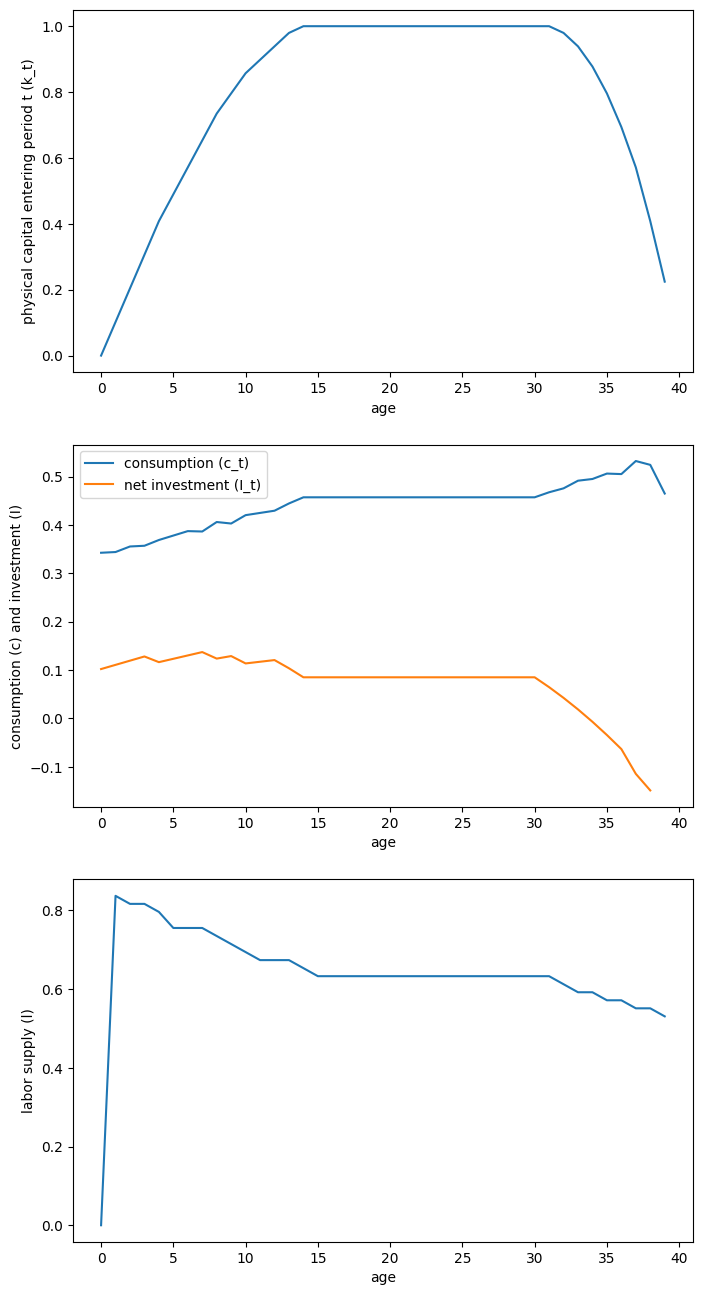

iter: 1; K change: 0.24; H change: 0.00; L change: 0.19; Z change: 0.03
tax_revenue: 0.03778403079085644
grants: 0.025515684627999594
T: 0.041429128594856396
iter: 1; K: 0.40; H: 1.00; L: 0.37; Z: 0.10
iter: 1; Y: 0.36; tau: 0.15; T: 0.04
[-3.33339767 -3.19063231 -3.0560328  -2.92935652 -2.8099813  -2.69741865
 -2.59133418 -2.49136658 -2.39718087 -2.30846517 -2.22492789 -2.14548095
 -2.07048099 -1.99988433 -1.93295231 -1.86935334 -1.80954873 -1.75239136
 -1.69842033 -1.64714656 -1.59836698 -1.55211292 -1.50798581 -1.4660488
 -1.42611487 -1.38791752 -1.35177979 -1.31684327 -1.28377993 -1.25207792
 -1.2216525  -1.19275355 -1.16488466 -1.13814982 -1.11267528 -1.08815338
 -1.06447615 -1.04185154 -1.02021086 -0.99915926 -0.97893173 -0.95953748
 -0.94092606 -0.92282063 -0.90534033 -0.88853092 -0.87235449 -0.85677595
 -0.84152292 -0.82681401]
iter: 1, i: 39, k: 0.39714285714285713, l: 0.3683673469387755
k_opt: 0.0, l_opt: 0.7346938775510203, asset: 0.0, value: -6.450124482597985
k_opt: 0.0204

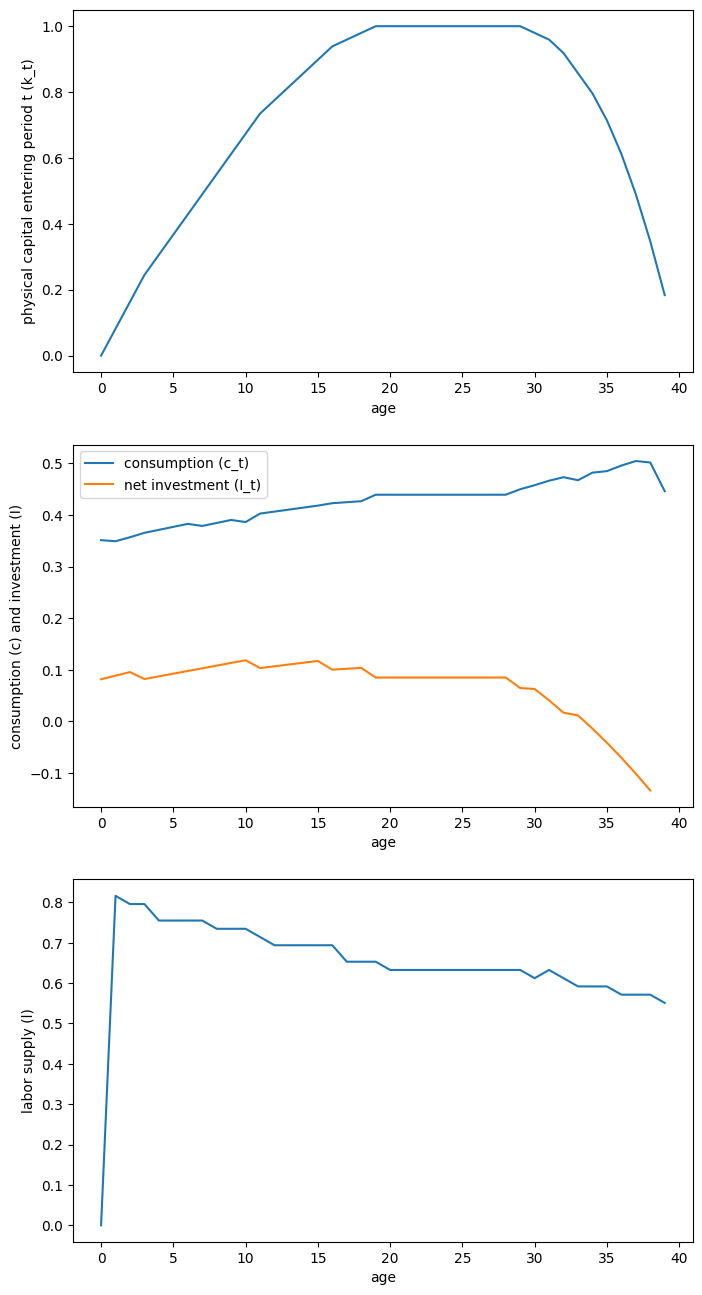

iter: 2; K change: 0.14; H change: 0.00; L change: 0.13; Z change: 0.05
tax_revenue: 0.04241579949505142
grants: 0.02877969256258953
T: 0.04652718414684993
iter: 2; K: 0.46; H: 1.00; L: 0.42; Z: 0.11
iter: 2; Y: 0.41; tau: 0.15; T: 0.05
[-3.34973306 -3.20488074 -3.06873152 -2.94070959 -2.82029464 -2.70701396
 -2.60002509 -2.49915148 -2.40413984 -2.31466985 -2.23044251 -2.15091533
 -2.07532645 -2.00418736 -1.93724386 -1.87317481 -1.81293475 -1.75580816
 -1.70145487 -1.65022003 -1.60110233 -1.55489258 -1.5104644  -1.46857507
 -1.42837142 -1.39022373 -1.35384304 -1.31895714 -1.28593611 -1.25402269
 -1.22364046 -1.19477105 -1.16672347 -1.14002589 -1.11458311 -1.08989692
 -1.06625215 -1.04365543 -1.02193239 -1.00084524 -0.98064241 -0.96126941
 -0.94261738 -0.92444723 -0.90698602 -0.89019304 -0.87403065 -0.85834753
 -0.84310548 -0.82840944]
iter: 2, i: 39, k: 0.4613877551020408, l: 0.4246938775510204
k_opt: 0.0, l_opt: 0.7142857142857142, asset: 0.0, value: -6.481733473045208
k_opt: 0.020408

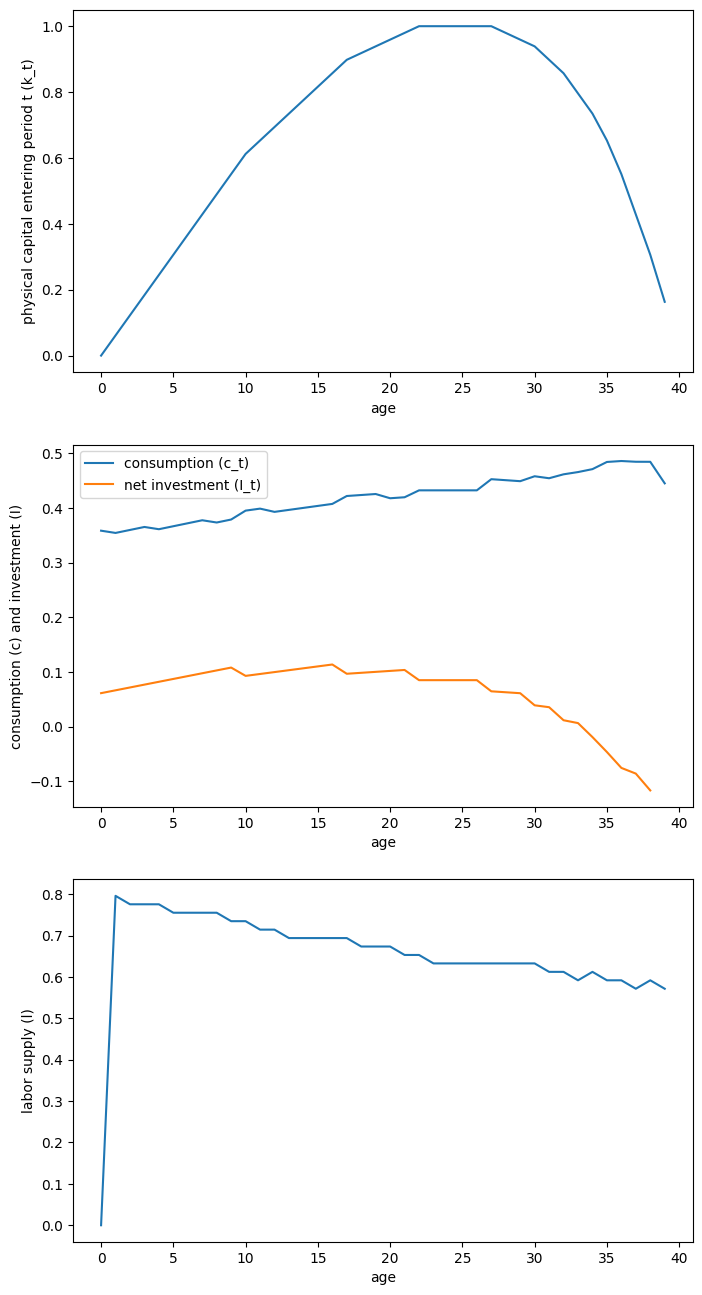

iter: 3; K change: 0.08; H change: 0.00; L change: 0.10; Z change: 0.06
tax_revenue: 0.04615486659296842
grants: 0.03132838646494587
T: 0.05063035037367497
iter: 3; K: 0.50; H: 1.00; L: 0.47; Z: 0.11
iter: 3; Y: 0.45; tau: 0.15; T: 0.05
[-3.36401504 -3.21716463 -3.07923607 -2.94962533 -2.82778813 -2.71323137
 -2.60550587 -2.50379741 -2.40785314 -2.31753758 -2.23254244 -2.15257939
 -2.07664423 -2.00491968 -1.93746787 -1.87337968 -1.81268329 -1.75559411
 -1.7008483  -1.64945435 -1.60021285 -1.55382757 -1.50934867 -1.46744967
 -1.42707436 -1.3890135  -1.35240052 -1.31760507 -1.28448887 -1.25255592
 -1.2222587  -1.19321171 -1.16525    -1.13863191 -1.11311646 -1.08842872
 -1.06485811 -1.04233049 -1.02047764 -0.9994596  -0.97932142 -0.960009
 -0.94124603 -0.92313635 -0.90573197 -0.88899248 -0.87287016 -0.85710441
 -0.8419127  -0.82726423]
iter: 3, i: 39, k: 0.503395918367347, l: 0.47097959183673466
k_opt: 0.0, l_opt: 0.7142857142857142, asset: 0.0, value: -6.509369109045085
k_opt: 0.02040816

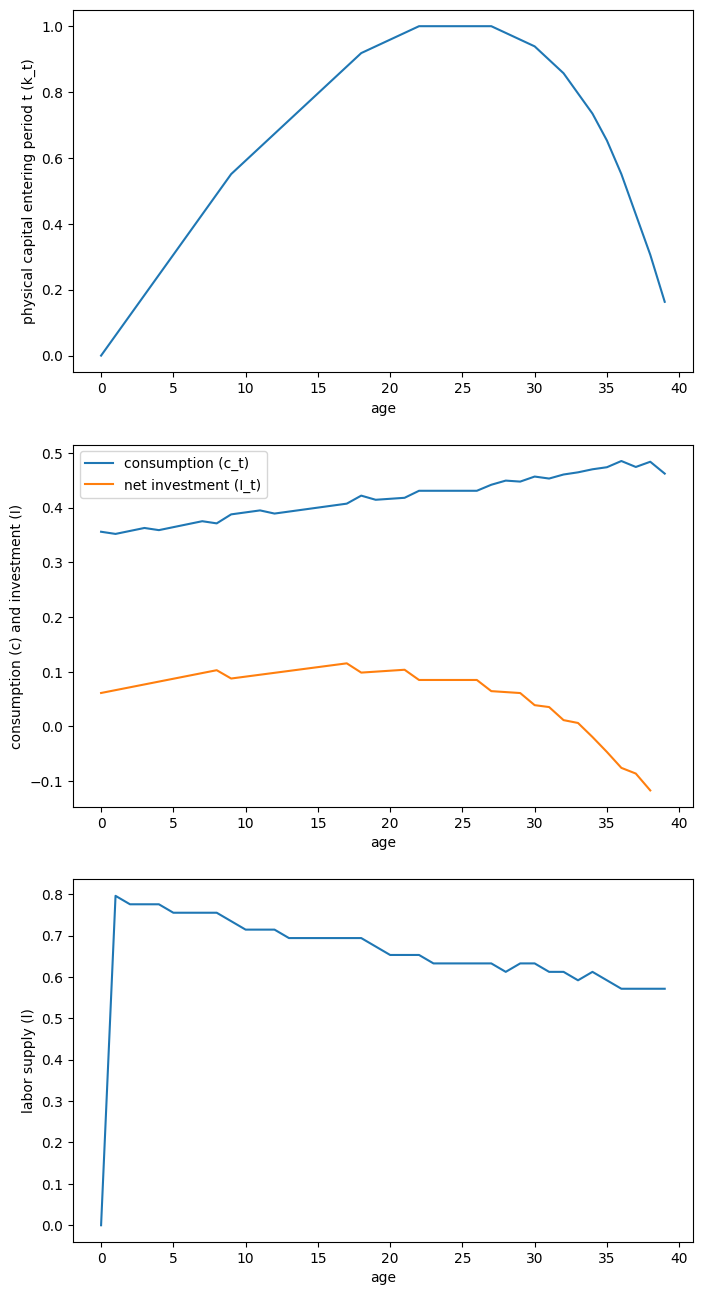

iter: 4; K change: 0.06; H change: 0.00; L change: 0.07; Z change: 0.06
tax_revenue: 0.04918087840709406
grants: 0.033380474308900114
T: 0.05394951759407979
iter: 4; K: 0.54; H: 1.00; L: 0.51; Z: 0.12
iter: 4; Y: 0.48; tau: 0.15; T: 0.05
[-3.36692804 -3.21918703 -3.08047346 -2.95016913 -2.82771784 -2.71261634
 -2.60440681 -2.50267067 -2.4064535  -2.31578413 -2.23047169 -2.15022387
 -2.0744704  -2.00250583 -1.93483731 -1.87093684 -1.81005483 -1.75286358
 -1.69823692 -1.64669671 -1.597629   -1.55111569 -1.50679955 -1.46478766
 -1.42456486 -1.38660535 -1.34993383 -1.31526984 -1.28206697 -1.25025785
 -1.22007513 -1.19095241 -1.16309898 -1.1365815  -1.11099932 -1.08640706
 -1.06292556 -1.04044271 -1.01857067 -0.9976321  -0.97756848 -0.95830018
 -0.93951274 -0.92147019 -0.90412909 -0.8874493  -0.87128262 -0.8555743
 -0.84043693 -0.82583993]
iter: 4, i: 39, k: 0.5361861224489797, l: 0.5075999999999999
k_opt: 0.0, l_opt: 0.7142857142857142, asset: 0.0, value: -6.515005764586179
k_opt: 0.020408

In [20]:
from scipy.optimize import minimize


iteration = -1
K_diff = 1 + tolerance
state_var_iter_array = np.zeros((max_iters,4))

#loop while max_iters not exceeded and difference between this K guess and previous K guess is greater than acceptable tolerance
while iteration < max_iters - 1 and K_diff > tolerance:
  iteration += 1
  K_diff = abs((K_bar - K_old) / K_bar)
  H_diff = abs((H_bar - H_old) / H_bar)
  L_diff = abs((L_bar - L_old) / L_bar)
  Z_diff = abs((Z_bar - Z_old) / Z_bar)
  print(f"iter: {iteration}; K change: {K_diff:.2f}; H change: {H_diff:.2f}; L change: {L_diff:.2f}; Z change: {Z_diff:.2f}")

  #calculate variables based on new guess of K, H, L
  w = wage_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  r = interest_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  Y = production(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  grants = G_gdp * Y

  Iz = Iz_gdp * Y
  Ie = Ie_gdp * Y

  tax_revenue = tau*w*H_bar*L_bar + tau*r*K_bar
  print(f"tax_revenue: {tax_revenue}")
  print(f"grants: {grants}")
  T = tax_revenue + grants
  T = transfer(K_prev = K_bar, H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r) - Iz
  print(f"T: {T}")

  print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}; Z: {Z_bar:.2f}")
  print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")

  #set the old state variables to be previous iteration state variables
  K_old = K_bar
  H_old = H_bar
  L_old = L_bar
  Z_old = Z_bar
  state_var_iter_array[iteration, 0] = K_old
  state_var_iter_array[iteration, 1] = H_old
  state_var_iter_array[iteration, 2] = L_old
  state_var_iter_array[iteration, 3] = Z_old

  value_array = np.zeros((na, periods + 1)) #value function array for each k,l combination
  k_optimal_array = np.zeros((na, periods)) #optimal capital array
  c_optimal_array = np.zeros((na, periods)) #optimal consumption array
  l_optimal_array = np.zeros((na, periods)) #optimal labor array
  h_optimal_array = np.zeros((na, periods)) #optimal human capital array
  hc_optimal_array = np.zeros((na, child_periods)) #optimal child human capital array

  #compute last period value function
  for i in range(na): #different k_t-1 possible
    for j in range(nl): #different l_t choices
      final_period_assets = (1-tau)*w*H_bar*l_grid[j] + (1+r)*k_grid[i] - tau*r*max(k_grid[i], 0) + T
      value = utility(final_period_assets, l_grid[j])
      if j == 0 or value > value_array[i, periods - 1]:
          value_array[i, periods - 1] = value
          l_optimal_array[i, periods - 1] = l_grid[j]

  print(value_array[:, periods - 1])
      # c_optimal_array[i,j, periods - 1] = final_period_assets
      # # For final period, optimal labor solves static maximization of utility
      # # Find optimal l that maximizes u(c,l) where c = (1-tau)*w*H*l + (1+r)*k - tau*r*k + T
      # def labor_objective(l):
      #     c = (1-tau)*w*H_bar*l + (1+r)*k_grid[i] - tau*r*max(k_grid[i],0) + T
      #     return -utility(c, l)  # Negative since we're minimizing
      
      # result = minimize(labor_objective, x0=0.5, bounds=[(0, 1)], method='L-BFGS-B')
      # l_optimal_array[i,j, periods - 1] = result.x

      # h_optimal_array[i,j, periods - 1] = h

  #compute policy function
  for i in range(periods-1, 0, -1): #loop backwards from age 60 to 0
    print(f"iter: {iteration}, i: {i}, k: {K_bar}, l: {L_bar}")
    
    # Create 2D interpolator over k and l grids
    # vr_polate = interpolate.RectBivariateSpline(k_grid, l_grid, value_array[:,i])
    vr_polate = interpolate.interp1d(k_grid, value_array[:,i], kind='cubic', fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i


    # for j in range(na): #iterate over possible initial capital
    #   for n in range(nl): #iterate over possible initial labor
    #     k0 = k_grid[j]
    #     l0 = l_grid[n]

    #     # Find optimal k and l using grid search over both dimensions
    #     max_value = float('-inf')
    #     k_opt = 0
    #     l_opt = 0
        
    #     for k_idx in range(na):
    #       for l_idx in range(nl):
    #         k = k_grid[k_idx]
    #         l = l_grid[l_idx]
    #         val = value_function(vr_polate, k, k0, l, h, w, r, tau, T)
            
    #         if val > max_value:
    #           max_value = val
    #           k_opt = k
    #           l_opt = l

    #     k_optimal_array[j,n,i-1] = k_opt
    #     l_optimal_array[j,n,i-1] = l_opt
    #     value_array[j,n,i-1] = max_value
    #     print('checkpoint 1', k_idx, l_idx)
    #     c_optimal_array[j,n,i-1] = (1-tau)*w*h*l_opt + r*k0 - tau*r*max(k0, 0) + T - k_opt

    for j in range(na):
        # for n in range(nl):
            k0 = k_grid[j]
            # l0 = l_grid[n]
            
            # Instead of grid search, use optimization methods
                    
            max_value = -np.inf
            max_k = None
            max_l = None

            for k_guess in k_grid:
                for l_guess in l_grid:
                    # Evaluate the value function at (k, l)
                    current_value = value_function(next_value_interpolator = vr_polate, k = k_guess, k_prev = k0, l = l_guess, h = h, w = w, r = r, tau = tau, T = T)
                    
                    # Update maximum if current_value is greater
                    if current_value >= max_value:
                        max_value = current_value
                        max_k = k_guess
                        max_l = l_guess


            
            k_opt, l_opt = max_k, max_l
            
            k_optimal_array[j, i-1] = k_opt
            l_optimal_array[j,i-1] = l_opt
            value_array[j,i-1] = max_value  
            print(f"k_opt: {k_opt}, l_opt: {l_opt}, asset: {k0}, value: {max_value}")
            c_optimal_array[j,i-1] = (1-tau)*w*h*l_opt + r*k0 - tau*r*max(k0, 0) + T - k_opt

    # for j in range(na):
    #     for n in range(nl):
    #         k0 = k_grid[j]
    #         l0 = l_grid[n]
            
    #         # First optimize k using binary search
    #         k_opt = binary_search_k(vr_polate, k0, l0, h, w, r, tau, T, k_min, k_max)
            
    #         # Then optimize l using standard minimize (since we don't assume monotonicity in l)
    #         def objective_l(l):
    #             return -value_function(vr_polate, k_opt, k0, l0, h, w, r, tau, T)
            
    #         result_l = minimize(objective_l, l0, bounds=[(l_min, l_max)], method='L-BFGS-B')
    #         l_opt = result_l.x[0]
            
    #         k_optimal_array[j,n,i-1] = k_opt
    #         l_optimal_array[j,n,i] = l_opt
    #         value_array[j,n,i-1] = -objective_l(l_opt)
    #         c_optimal_array[j,n,i] = (1-tau)*w*h*l_opt + r*k0 - tau*r*max(k0, 0) + T - k_opt


    # print('checkpoint 2')
  k_gen = np.zeros(periods)
  l_gen = np.zeros(periods)
  c_gen = np.zeros(periods)
  h_gen = np.zeros(periods)
  i_gen = np.zeros(periods)

  k_gen[0] = k_start
  # l_gen[0] = 0.2

  # Create interpolator for l policy function at first period
  # l_polate_init = interpolate.RectBivariateSpline(k_grid, l_grid, l_optimal_array[:,:,0])
  # l_gen[1] = l_polate_init(k_gen[0], l_start)[0,0]

  for q in range(periods - 1):
    # Create interpolators for k and l policy functions based on k_t-1
    l_polate = interpolate.interp1d(k_grid, l_optimal_array[:,q], kind='cubic', fill_value='extrapolate')
    l_gen[q+1] = l_polate(k_gen[q])


    k_polate = interpolate.interp1d(k_grid, k_optimal_array[:,q], kind='cubic', fill_value='extrapolate')
    k_gen[q+1] = k_polate(k_gen[q])
    # l_gen[q+1] = l_polate(k_gen[q])
    c_gen[q] = consumption(k_prev=k_gen[q], k=k_gen[q+1], h=h, l=l_gen[q+1], w=w, r=r, tau=tau, T=T) #CHECK THIS
    i_gen[q] = -c_gen[q] + (1-tau)*w*h*l_gen[q+1] + (r+delta)*k_gen[q] - tau*(r+delta)*max(k_gen[q], 0) + T #CHECK THIS

  K_new = np.mean(k_gen)
  L_new = np.mean(l_gen)

  K_bar = phi*K_old + (1-phi)*K_new
  L_bar = phi*L_old + (1-phi)*L_new

  Z_bar = (1-delta)*Z_old + (1-sigma_bar)*Iz

  final_period_assets = (1-tau)*w*H_bar*L_bar + (1+r)*k_gen[periods-1] - tau*r*max(k_gen[periods-1], 0) + T
  c_gen[periods-1] = final_period_assets

  print("Solution for aggregate capital stock K: " + str(K_bar))
  print("Solution for aggregate labor N: " + str(L_bar))

  fig, axes = plt.subplots(3, 1, figsize=(8, 16))
  axes[0].set_xlabel('age')
  axes[0].set_ylabel('physical capital entering period t (k_t)')
  axes[0].plot(k_gen)
  axes[1].set_xlabel('age')
  axes[1].set_ylabel('consumption (c) and investment (I)')
  axes[1].plot(c_gen, label='consumption (c_t)')
  axes[1].plot(i_gen[:-1], label='net investment (I_t)')
  axes[1].legend()
  axes[2].set_xlabel('age')
  axes[2].set_ylabel('labor supply (l)')
  axes[2].plot(l_gen)
  plt.show()


aggregates

In [ ]:
print("Aggregate Factors of Production:")
print(f"Y: {Y:.4f}")
print(f"Z: {Z_old:.4f}")
print(f"K: {K_old:.4f}")
print(f"H: {H_old:.4f}")
print(f"L: {L_old:.4f}")
print("\nRates:")
print(f"Interest rate (r): {r:.4f}")
print(f"Return on capital (r^k): {r + delta:.4f}")


Aggregate Factors of Production:
Y: nan
Z: 0.1599
K: nan
H: 1.0000
L: nan

Rates:
Interest rate (r): nan
Return on capital (r^k): nan
